<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---


<p align="center"><h1 align="center">ClimateBench Model Submission Guide

##### <p align="center">*Source: [ClimateBench Github](https://github.com/duncanwp/ClimateBench)* 

---
Let's share our models to a centralized leaderboard, so that we can collaborate and learn from the model experimentation process...

**Instructions:**
1.   Get data in and set up X_train / X_test / y_train
2.   Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model 
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard

## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [ ]:
! pip install importlib-metadata==4.13.0

In [3]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/climatebench_competition_data-repository:latest') 


Data downloaded successfully.


In [2]:
# Load data in 
import shutil
import xarray as xr

shutil.copy("climatebench_competition_data/utils.py", "utils.py")
from utils import * 

train_path = os.path.join("climatebench_competition_data",'Data','train_val')
test_path  = os.path.join("climatebench_competition_data",'Data','test')

# Training set
train_files    = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)

In [6]:
print(X_train_xr.dims)
print(X_test_xr.dims)
print(y_train_xr.dims)

Frozen({'time': 753, 'longitude': 144, 'latitude': 96})
Frozen({'time': 86, 'longitude': 144, 'latitude': 96})
Frozen({'time': 753, 'latitude': 96, 'longitude': 144})


##2.   Preprocess Data / Write and Save Preprocessor function


In [7]:
#### Select relevant variables for Model 1 

## predictors: CO2 & CH4 
## predictand: tas (Annual Mean global distributions of temperature)

import pandas as pd 

X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [8]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


In [9]:
# "Note that here we stack the original 2-D tas data into a single dimension (for the purpose of NN implementation)" 
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

In [10]:
# Preprocessor Function

def preprocessor(data):
    #Standardize inputs based on X_train mean and standard deviation
    mean, std = X_train_df.mean(), X_train_df.std()
    data   = (data - mean)/std
    preprocessed_data = data.to_numpy()
    return preprocessed_data

In [11]:
# Check shape for keras input:
preprocessor(X_train_df).shape 

(753, 2)

In [14]:
X_train = preprocessor(X_train_df)
y_train = y_train_df.to_numpy()
X_test = preprocessor(X_test_df)

##3. Fit model on preprocessed data and save preprocessor function and model 


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

In [12]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [17]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 13824)             898560    
                                                                 
Total params: 907,072
Trainable params: 907,072
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

#### Save preprocessor function to local "preprocessor.zip" file

In [20]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [21]:
# Test Preprocessor 
prep = ai.import_preprocessor("preprocessor.zip")
prep(X_train_df).shape

(753, 2)

#### Save model to local ".onnx" file

In [22]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features there are
from skl2onnx.common.data_types import FloatTensorType

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [23]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials
    
apiurl="https://m5bxhotlm5.execute-api.us-east-1.amazonaws.com/prod/m"
#This is the unique rest api that powers this CA Housing Prediction Playground

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [24]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1: 

#-- Generate predicted values (Mean surface air temperature - TAS)
# Reshape and convert to list in order to calculate model metrics
predicted_values = model.predict(preprocessor(X_test_df))
predicted_values = predicted_values.reshape(predicted_values.shape[0], 96, 144)
predicted_values = predicted_values.tolist()

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=predicted_values)

In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

## 5. Repeat submission process to improve place on leaderboard
Model 2 - Convolutional Neural Network 

In [29]:
#format y data 
y_train = y_train_xr['tas'].data

In [30]:
# predictors: 1-D time series of CO2 & CH4
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


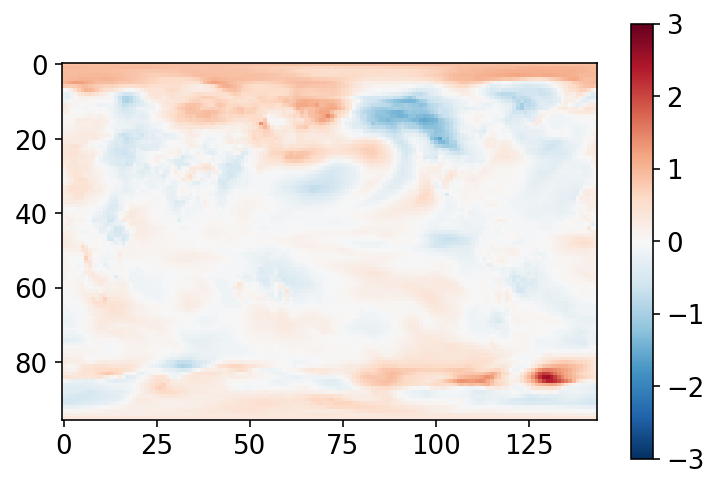

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

# predictand:  2-D map of tas (Annual Mean global distributions of temperature)
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar()

In [34]:
# Check Shape of Data 
# Note that you can create and use a different preprocessor, but we used the same one here 
print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 96, 144) (86, 2)


In [35]:
# Define Hyperparameters for Model 2 

n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [36]:
model = Sequential()

model.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6912)              20736     
                                                                 
 reshape (Reshape)           (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 36, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 72, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 144, 32)      16416     
 ranspose)                                                       
                                                      

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

In [38]:
# Save Model 2 to .onnx file

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model_2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# Submit Model 2

#-- Generate predicted values (Mean surface air temperature - TAS)
# Reshape and convert to list in order to calculate model metrics
predicted_values = model.predict(preprocessor(X_test_df))
predicted_values = predicted_values.reshape(predicted_values.shape[0], 96, 144)
predicted_values = predicted_values.tolist()

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model_2.onnx",
                                 prediction_submission=predicted_values,
                                 preprocessor_filepath="preprocessor.zip")

In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

In [ ]:
# Compare two or more models
data=mycompetition.compare_models([1, 2], verbose=1)
mycompetition.stylize_compare(data)